# Read Multimeter output from picture
This (should) be useful for my Laborator
io di Elettromagnetismo e Circuiti first lab experience in which the objective is to measure the voltage of a capacitor during a long period (15 min) discharge  

In [2]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.utils import to_categorical
from ipywidgets import IntProgress
from IPython.display import display

2024-03-26 18:25:28.395453: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 18:25:29.550715: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The dataset is from https://connormonahan.net/2020/09/27/seven-segment-display-dataset.html

In [3]:
features = np.load("sevensegdataset.npy")

x_train = features[:, :-1]
y_train = features[:, -1]

x_train = x_train.reshape((-1, 28, 28))
y_train = to_categorical(y_train)

x_train = x_train.astype("float32") / 255.0

model = Sequential()

model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/opt/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [4]:
model.fit(x_train, y_train, epochs=2)

Epoch 1/2


2024-03-26 18:25:35.411135: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 54186944 exceeds 10% of free system memory.


409/540 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8870 - loss: 0.4370

540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9089 - loss: 0.3562
Epoch 2/2
540/540 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 1.0000 - loss: 5.6533e-04


In [5]:
def show_image(img, axis=False):
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if not axis:
        plt.axis("off")
    plt.imshow(image_rgb)
    plt.show()

In [6]:
video = "tests/video1/coincell_led_rgb.mp4"
frames = "tests/frames1/"

video_cv = cv2.VideoCapture(video)

fps = video_cv.get(cv2.CAP_PROP_FPS)
interval_between_frames = 0.5 #seconds
interval = int(fps * interval_between_frames)

frame_count = 0

while video_cv.isOpened():
    ret, frame = video_cv.read()
    
    if ret:
        if frame_count % interval == 0:
            frame_index = (frame_count // interval) * interval_between_frames
            filename = os.path.join(frames, f"{str(frame_index).replace('.', '_')}.jpg")
            cv2.imwrite(filename, frame)
        
        frame_count += 1
    else:
        break
    
video_cv.release()

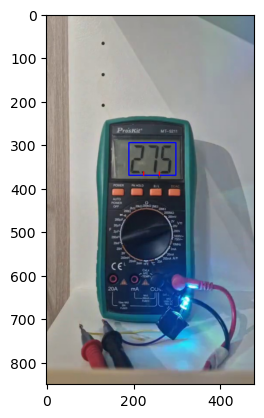

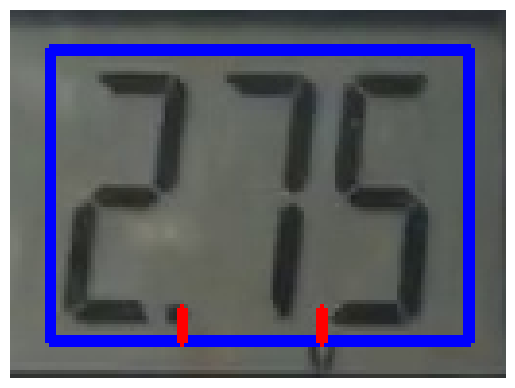

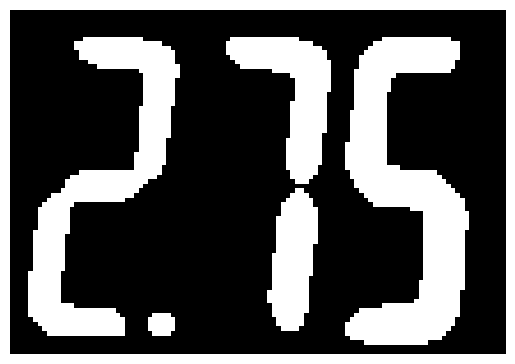

In [7]:
digits_count = 3 # Number of digits on the display
decimal_point_line = 0.1 # Percentage of height to check
decimal_point_offset = -2

def load_image_and_crop(filename, x1, y1, x2, y2, show_image_flag=False):
    multimeter_image = cv2.imread(filename, cv2.IMREAD_COLOR)
    display_multimeter_image = multimeter_image.copy()
    
    cv2.rectangle(display_multimeter_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    line_count = digits_count - 1
    line_spacing = (x2 - x1) / (line_count + 1)
    
    for i in range(1, line_count + 1):
        line_x = int(x1 + i * line_spacing) + decimal_point_offset
        cv2.line(display_multimeter_image, (line_x, int(y1 + (y2 - y1) * (1 - decimal_point_line))), (line_x, y2), (0, 0, 255), 2)

    if show_image_flag:
        show_image(display_multimeter_image, axis=True)
        show_image(display_multimeter_image[y1-10:y2+10, x1-10:x2+10])
    
    ocr_image = multimeter_image[y1:y2, x1:x2]
    ocr_image = cv2.cvtColor(ocr_image, cv2.COLOR_BGR2GRAY)
    
    # enable if 7s become 1s
    ocr_image = cv2.GaussianBlur(ocr_image, (5, 5), 0)
    ocr_image = cv2.GaussianBlur(ocr_image, (5, 5), 0)
    ocr_image = cv2.GaussianBlur(ocr_image, (5, 5), 0)
    
    _, ocr_image = cv2.threshold(ocr_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    ocr_image = cv2.bitwise_not(ocr_image)
    
    if show_image_flag:
        show_image(ocr_image)
    
    return ocr_image

x1 = 190
y1 = 295
 
x2 = 298
y2 = 370
 
ach_image = load_image_and_crop("tests/frames1/2_5.jpg", x1, y1, x2, y2, show_image_flag=True)

In [8]:
def find_decimal_point(image):
    # Re-examining the approach with adjustments
    height, width = image.shape
    
    comma_index = digits_count
    line_count = digits_count - 1
    
    line_spacing = width / digits_count

    for i in range(1, line_count + 1):
        line_x = int(i * line_spacing) + decimal_point_offset
        
        column_pixels = image[int(height * (1 - decimal_point_line)):, line_x:line_x+1]#.reshape(height + 0.9 * height, 1)
        
        if np.any(np.all(column_pixels == [255, 255, 255], axis=-1)):
            comma_index = i
            break

    return comma_index

ach_decimal_point = find_decimal_point(ach_image)
ach_decimal_point

1

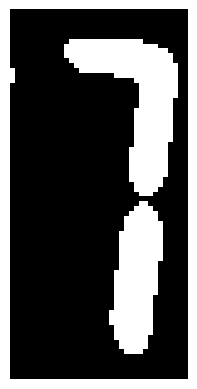

In [9]:
def split_digits(image):
    height, width = image.shape[:2]
    quarter_width = width // digits_count

    digits = []

    for i in range(digits_count):
        start_x = i * quarter_width
        end_x = (i + 1) * quarter_width if (i < 3) else width
        segment = image[:, start_x:end_x]

        total_pixels = segment.size
        white_pixels = cv2.countNonZero(segment)
        white_percentage = (white_pixels / total_pixels)

        if white_percentage < 0.1:
            digits.append(None)
        else:
            digits.append(segment)

    return digits

ach_image_digits = split_digits(ach_image)
show_image(ach_image_digits[1])

In [10]:
def read_digit(image):
    nn_image = cv2.resize(image, (28, 28))

    image_array = nn_image.reshape(1, 28, 28, 1)
    image_array = image_array.astype("float32") / 255.0

    predictions = model.predict(image_array, verbose=0)
    predicted_digit = np.argmax(predictions[0])

    return predicted_digit

def read_and_join_digits(images, decimal_point):
    value = 0
    for i, image in enumerate(images):
        if image is not None:
            value += read_digit(image) * 10 ** (digits_count - 1 - i)
    return value / 10 ** (digits_count - decimal_point)

print("First digit is", read_digit(ach_image_digits[0]), "\n"
      "Whole number is", read_and_join_digits(ach_image_digits, ach_decimal_point))

First digit is 2 
Whole number is 2.75


# Actual execution

In [11]:
# Set these above!

# x1 = 190
# y1 = 180
 
# x2 = 310
# y2 = 275

values = []

frames_list = os.listdir(frames)
f = IntProgress(min=0, max=len(frames_list))
display(f)

for file in frames_list:    
    if file.startswith("."):
        continue
    
    filename = os.path.join(frames, file)    
    timestamp = float(os.fsdecode(file).split(".")[0].replace("_", "."))
    
    image = load_image_and_crop(filename, x1, y1, x2, y2)
    
    decimal_point = find_decimal_point(image)
    
    digits = split_digits(image)
    value = read_and_join_digits(digits, decimal_point)
    
    values.append((timestamp, value))
    f.value += 1
    

IntProgress(value=0, max=507)

In [ ]:
values

[(0.0, 2.86),
 (0.5, 2.81),
 (1.0, 2.73),
 (1.5, 2.8),
 (2.0, 2.73),
 (2.5, 2.75),
 (3.0, 2.78),
 (3.5, 2.73),
 (4.0, 2.71),
 (4.5, 2.79),
 (5.0, 2.77),
 (5.5, 2.8),
 (6.0, 2.8),
 (6.5, 2.8),
 (7.0, 2.76),
 (7.5, 2.77),
 (8.0, 2.72),
 (8.5, 2.75),
 (9.0, 2.73),
 (9.5, 2.8),
 (10.0, 2.72),
 (10.5, 2.74),
 (11.0, 2.73),
 (11.5, 2.73),
 (12.0, 2.7),
 (12.5, 2.79),
 (13.0, 2.72),
 (13.5, 2.79),
 (14.0, 2.8),
 (14.5, 2.79),
 (15.0, 2.7),
 (15.5, 2.78),
 (16.0, 2.73),
 (16.5, 2.74),
 (17.0, 2.79),
 (17.5, 2.78),
 (18.0, 2.79),
 (18.5, 2.74),
 (19.0, 2.73),
 (19.5, 2.75),
 (20.0, 2.72),
 (20.5, 2.75),
 (21.0, 2.72),
 (21.5, 2.79),
 (22.0, 2.71),
 (22.5, 2.73),
 (23.0, 2.7),
 (23.5, 2.78),
 (24.0, 2.75),
 (24.5, 2.79),
 (25.0, 2.78),
 (25.5, 2.78),
 (26.0, 2.79),
 (26.5, 2.79),
 (27.0, 2.77),
 (27.5, 2.75),
 (28.0, 2.72),
 (28.5, 2.75),
 (29.0, 2.76),
 (29.5, 2.77),
 (30.0, 2.71),
 (30.5, 2.73),
 (31.0, 2.7),
 (31.5, 2.74),
 (32.0, 2.74),
 (32.5, 2.79),
 (33.0, 2.77),
 (33.5, 2.8),
 (34.0, 2.8

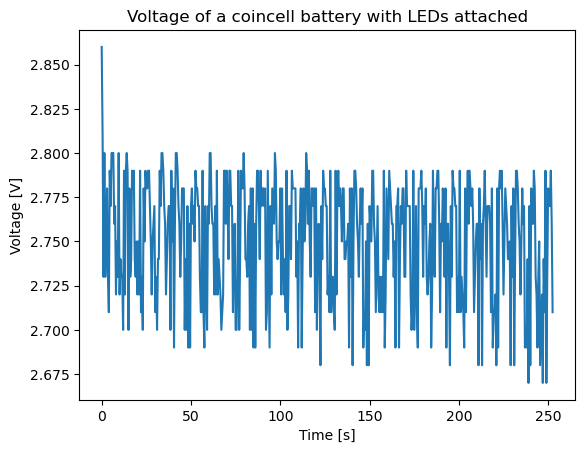

In [ ]:
plt.title("Voltage of a coincell battery with LEDs attached")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.plot(np.array(values).T[0], np.array(values).T[1])
plt.show()